In [1]:
!nvidia-smi

Tue Mar 22 01:24:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, auc
import seaborn as sns
import os
import keras as K
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, BatchNormalization, Activation
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [3]:
# !gdown --id 1t6YeP6-XrUPXSiqys1isH1yJzyRbYB64 --output "data.zip" # 1137 taxa
# !gdown --id 1HR7rPqEzgqKn3VniniHTEAAec9NaD8n9 --output "data.zip" # distance
# !gdown --id 1-zNZrjPTm_pLy4WEU0bHqnfGnxSjvje4 --output "data.zip" # without log
# !gdown --id 1ychy70kl48AYx9Sm2B7LsVcCaL2km_-H --output "data.zip" # 496 taxa
# !gdown --id 1I2ZPnTWqenR6aeTv6w-w-fObqmvlfOg_ --output "data.zip" # 496 taxa, distance normalized total sum
# !gdown --id 1krwdMH7ZsbIubfANeiXacy1irQE9Nixo --output "data.zip" # 496 taxa, distance normalized maximum sum
!gdown --id 1eZai1_DE_zoJPLWicrlmcJTj0h0phpSu --output "data.zip" # 1137 taxa, distance normalized maximum sum

!unzip -q "data.zip"

Downloading...
From: https://drive.google.com/uc?id=1eZai1_DE_zoJPLWicrlmcJTj0h0phpSu
To: /content/data.zip
100% 20.7M/20.7M [00:00<00:00, 188MB/s]


In [4]:
train = pd.read_csv('label/label.csv')
train.head()

,Filename,Index,Diagnosis
0,laplacian_matrix_1_species_new.csv,SRR7142497,1
1,laplacian_matrix_2_species_new.csv,SRR7142491,0
2,laplacian_matrix_3_species_new.csv,SRR7142505,1
3,laplacian_matrix_4_species_new.csv,SRR7142475,0
4,laplacian_matrix_5_species_new.csv,SRR7142509,0


In [5]:
filename = train['Filename']
filename_list = [os.path.join('matrix/',i) for i in filename] 
label = train['Diagnosis']
# label_list = []
# for i in range(len(label)):
#     label_list.append(label[i])
# print(filename_list)
# print(label_list)
label = np.array(label, dtype=np.float32)

In [7]:
matrix_list = []
for index in range(443):
    matrix = []
    with open('matrix/laplacian_matrix_'+str(index+1)+'_species_new.csv','r') as f:
        rows = csv.reader(f)
        for row in rows:
            matrix.append(row[:-1])
        matrix = np.array(matrix, dtype=np.float32)
        matrix_list.append(matrix)

In [8]:
matrix_list = np.array(matrix_list)
matrix_list = np.squeeze(matrix_list,axis=1)
matrix_list = pd.DataFrame(matrix_list)

In [10]:
train_x, test_x, train_y, test_y = train_test_split(matrix_list,label,test_size=0.2,random_state=0)
print(train_x.shape)
print(test_x.shape)
sample_list = list(test_x.index)
train_x = train_x.values.reshape(354, 1, 1137, 1137)
test_x = test_x.values.reshape(89, 1, 1137, 1137)

print(train_x.shape)
print(test_x.shape)

(354, 1292769)
(89, 1292769)
(354, 1, 1137, 1137)
(89, 1, 1137, 1137)


In [12]:
# 1137 taxa
model = K.models.Sequential()
model.add(K.layers.Conv2D(32, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
model.add(K.layers.BatchNormalization(axis=1, momentum=0.99, epsilon=1e-05, center=True, scale=True))
model.add(K.layers.Conv2D(16, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
model.add(K.layers.BatchNormalization(axis=1, momentum=0.99, epsilon=1e-05, center=True, scale=True))
model.add(K.layers.Flatten())
model.add(K.layers.Dropout(0.4))
model.add(K.layers.BatchNormalization(axis=1, momentum=0.99, epsilon=1e-05, center=True, scale=True))
model.add(K.layers.Dense(12, activation= 'relu'))
model.add(K.layers.Dropout(0.2))
model.add(K.layers.BatchNormalization(axis=1, momentum=0.99, epsilon=1e-05, center=True, scale=True))
model.add(K.layers.Dense(1,activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 1137, 32)       36416     
                                                                 
 batch_normalization (BatchN  (None, 1, 1137, 32)      4         
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1137, 16)       528       
                                                                 
 batch_normalization_1 (Batc  (None, 1, 1137, 16)      4         
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 18192)             0         
                                                                 
 dropout (Dropout)           (None, 18192)             0

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.0006)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

h2 = model.fit(train_x, train_y, epochs=50, batch_size=8, validation_data=(test_x, test_y), callbacks=[callback])

Epoch 1/50
45/45 [==============================] - 16s 72ms/step - loss: 0.8731 - accuracy: 0.5028 - auc: 0.5252 - val_loss: 0.6628 - val_accuracy: 0.7303 - val_auc: 0.7436
Epoch 2/50
45/45 [==============================] - 2s 37ms/step - loss: 0.7051 - accuracy: 0.6073 - auc: 0.6542 - val_loss: 0.6133 - val_accuracy: 0.6854 - val_auc: 0.7171
Epoch 3/50
45/45 [==============================] - 2s 37ms/step - loss: 0.6064 - accuracy: 0.6864 - auc: 0.7538 - val_loss: 0.6493 - val_accuracy: 0.5843 - val_auc: 0.7385
Epoch 4/50
45/45 [==============================] - 2s 37ms/step - loss: 0.5706 - accuracy: 0.6921 - auc: 0.7806 - val_loss: 0.5717 - val_accuracy: 0.7303 - val_auc: 0.7345
Epoch 5/50
45/45 [==============================] - 2s 37ms/step - loss: 0.5531 - accuracy: 0.7345 - auc: 0.8064 - val_loss: 0.5895 - val_accuracy: 0.7079 - val_auc: 0.7463
Epoch 6/50
45/45 [==============================] - 2s 37ms/step - loss: 0.5089 - accuracy: 0.7655 - auc: 0.8297 - val_loss: 0.5725 - 

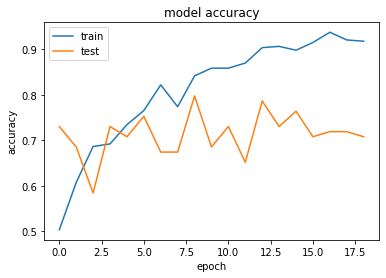

In [18]:
# summarize history for accuracy
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

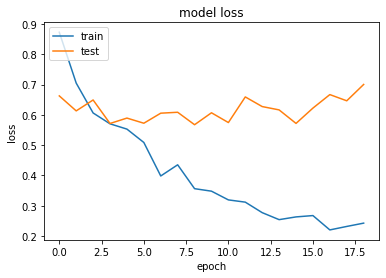

In [19]:
# summarize history for accuracy
plt.plot(h2.history['loss'])
plt.plot(h2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

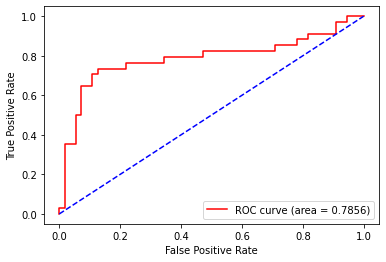

In [20]:
y_pred = model.predict(test_x)
# Plot auc curve
fp, tp, _ = roc_curve(test_y, y_pred)
roc_auc = auc(fp, tp)
plt.plot(fp, tp, label='ROC curve (area = %0.4f)' % roc_auc, color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='b', linestyle='--')
plt.legend(loc='lower right')

Text(91.68, 0.5, 'predicted label')

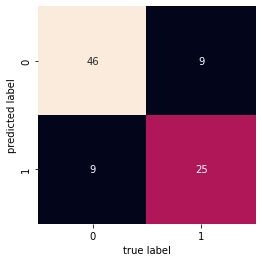

In [21]:
for i in range(len(y_pred)):
  if y_pred[i]<0.5:
    y_pred[i] = 0
  else:
    y_pred[i] = 1

# Confusion matrix
mat = confusion_matrix(test_y, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [22]:
score_recall = recall_score(test_y, y_pred, average=None)
F1 = f1_score(test_y, y_pred, average="macro")
precision = precision_score(test_y, y_pred, average=None)
auc_roc = roc_auc_score(test_y, y_pred)
print("precision = ",precision)
print("recall = ",score_recall)
print("auc_roc = ",auc_roc)
print("f1_score = ",F1)
model.save('CRC_Phylo-GCN.h5')
model.save_weights('CRC_Phylo-GCN.hdf5')
print('Model Saved')
with open('Phylo-GCN_result.csv','w') as f:
    f.write('Precision_Normal,Precision_Cancer,Recall_Normal,Recall_Cancer,Auc_Score,F1_Score,')
    f.write('\n')
    f.write(str(precision[0])+','+str(precision[1])+','+str(score_recall[0])+','+str(score_recall[1])+','+str(auc_roc)+','+str(F1))

precision =  [0.83636364 0.73529412]
recall =  [0.83636364 0.73529412]
auc_roc =  0.7858288770053476
f1_score =  0.7858288770053476
Model Saved


In [23]:
with open('Phylo-GCN_prediction.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['sample', 'diagnosis', 'predicted_diagnosis'])
        for i, p in enumerate(y_pred):
            writer.writerow([sample_list[i], test_y[i], int(p)])